In [1]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import math
#import plotly
#import plotly.express.colors as color
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data

In [121]:
dir = '/content/drive/MyDrive/projects/21_11_dacon_bicycle/'

bicycle = pd.read_csv(dir + '_data/train.csv')
t_bicycle = pd.read_csv(dir + '_data/test.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [122]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []
    
    for date in dataframe.date_time :
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

for D in [bicycle, t_bicycle]:
    year, month, day = seperate_datetime(D)
    D['year'] = year
    D['month'] = month
    D['day'] = day
    D['week'] = pd.to_datetime(D['date_time']).dt.week
    D['weekday'] = pd.to_datetime(D['date_time']).dt.weekday
    D.drop('date_time', axis=1, inplace=True)
    D['weekend'] =  ( D['weekday'] > 5 ) + 1
    D['precipitation_form'] = np.exp(D['precipitation_form'])
    
bicycle.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week,weekday,weekend
0,207.500,4.000,1.000000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,13,6,2
1,208.317,2.950,1.000000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,14,0,1
2,213.516,2.911,1.000000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,14,1,1
3,143.836,3.692,1.529590,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,14,2,1
4,95.905,4.000,2.060606,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,14,3,1


## 2.EDA

### 월별 총 대여량 상승폭

In [123]:
group = bicycle.groupby(['year','month'])['number_of_rentals']

In [124]:
total_rent_month = pd.DataFrame()

In [125]:
total_rent_month['mean'] = group.mean()
total_rent_month['std'] = group.std()
total_rent_month['min'] = group.min()
total_rent_month['max'] = group.max()

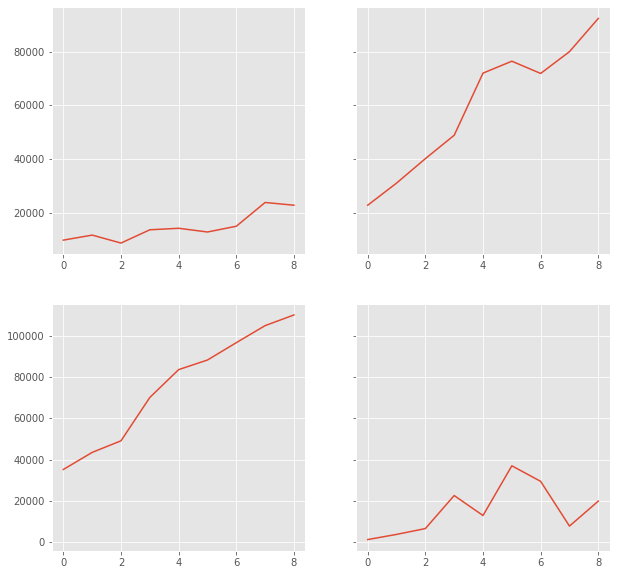

In [126]:
fig, ax = plt.subplots(2,2,sharey='row',figsize=(10,10))

ax[0][0].plot(list(total_rent_month['std']))
ax[0][1].plot(list(total_rent_month['mean']))
ax[1][0].plot(list(total_rent_month['max']))
ax[1][1].plot(list(total_rent_month['min']))

최대치가 꾸준하게 증가하는 것으로 보아, 따릉이에 대한 수요가 지속적으로 증가함을 확인할 수 있으며, 최소값과 표준편차는 해당월의 기후 변화에 영향을 받고 있는 것으로 예상해 볼 수 있다.

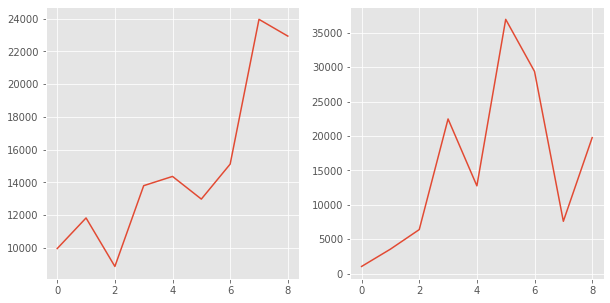

In [127]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(list(total_rent_month['std']))
ax[1].plot(list(total_rent_month['min']))

### 해당월의 일평균 강수량

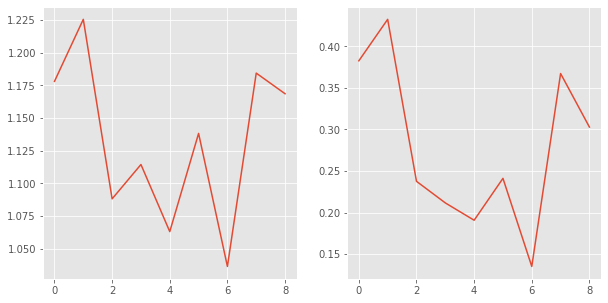

In [128]:
group = bicycle.groupby(['year','month'])['precipitation_form']

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(list(group.mean()))
ax[1].plot(list(group.std()))

In [129]:
total_rent_month['percip_mean'] = group.mean()
total_rent_month['percip_std'] = group.std()

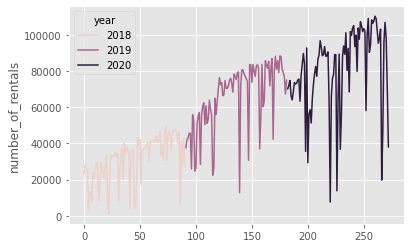

In [130]:
sns.lineplot(data=bicycle, 
             x=bicycle.index,
             y='number_of_rentals',
             hue='year',
             markers=True)

### 데이터 정리

가정 1. 주중 - 주말의 이용층이 다르다.   
주중 : 등하교 및 출퇴근 - 상대적으로 변수에 대해 덜 민감하고 평균기온즈음에 사용할것(9시 / 18시)
주말 : 여행 및 피크닉 - 상대적으로 변수에 더 민감하고 최고 기온 주변에서 사용할 것(12~17시)

가정 2. 따릉이 이용량은 꾸준히 증가해 왔고 앞으로도 그럴 것이다.

체감온도와 불쾌지수

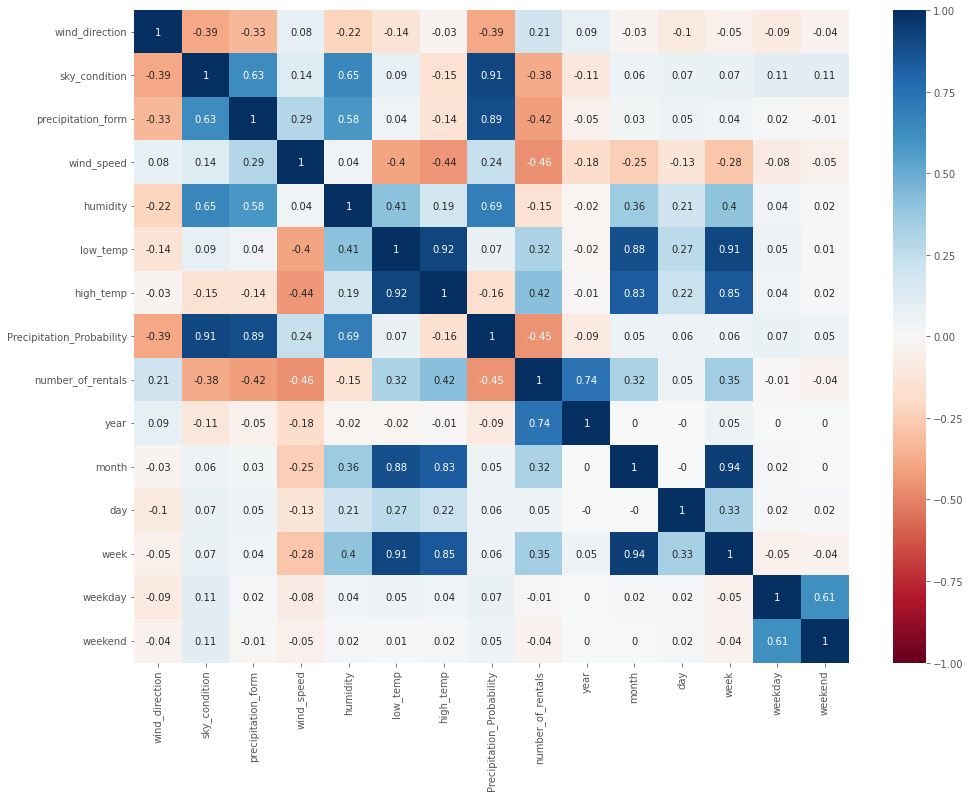

In [326]:
corr = np.round(bicycle.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(16,12))
hm = sns.heatmap(corr,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

### 데이터 분포

- wind_direction: 풍향 (degree)
- sky_condition : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 / 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

In [327]:
# masked_corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
# corr_rank = np.abs(masked_corr[masked_corr < 1]).unstack().sort_values(ascending = False).to_frame()
# corr_rank.dropna(inplace=True)

### 데이터 편집

독립성이 부족하거나 의미가 없는 데이터들을 통합 및 폐합, 새로운 데이터 생성

- 온도 통합 (평균)
- 강수량, 구름 삭제 (강수확률만 이용, 강수량은 시간대에 따른 변수가 있고, 강수확률이 있는 경우 따릉이 이용을 꺼려하는 경향이 있을 것이라고 가정)
- 의미없는 데이터 삭제(일, 요일)
- 의미를 알기 어려운 데이터 삭제(풍향)
- 습도는 불쾌지수로 사용하고 습도 자체 데이터는 삭제
- 기온은 평균기온과 최고기온을 사용

In [328]:
bicycle_new = bicycle.copy()
t_bicycle_new = t_bicycle.copy()

for D in [bicycle_new, t_bicycle_new]:
    
    #온도 통합 (평균, 최고기온)
    D['temp'] = (D['high_temp'] + D['low_temp']) / 2
    D.drop(['low_temp'], axis=1, inplace=True)
    
    #체감온도 
    D['feeling_temp'] = 13.12+0.6215*D['temp']-\
                        11.37*D['wind_speed']**(0.16)\
                        +0.3965*D['temp']*D['wind_speed']**(0.16)
    
    #불쾌지수
    D['temp_hum_index'] = 1.8*D['temp'] - 0.55 *\
                          (1 - D['humidity'])*(1.8*D['temp']-26) + 32
    
    D.drop(['temp'], axis=1, inplace=True)
    
    #습도삭제
    D.drop(['humidity'], axis=1, inplace=True)

    
    #강수확률 vs 강수형태 vs 구름 / 강수확률 우선테스트
    D.drop(['Precipitation_Probability', 'sky_condition'], axis=1, inplace=True)

    #의미없는 데이터 삭제(일, 요일)
    #선형적으로 증가한다는 가정
    D.drop(['weekday', 'day', 'weekend'], axis=1, inplace=True)

    #의미를 알기 어려운 데이터 삭제(풍향)
    D.drop(['wind_direction'], axis=1, inplace=True)

    #연도 가중치 강화
    #D['year2'] = D['year'] ** D['month']

#cum day
bicycle_new['cum_day'] = np.arange(len(bicycle)) + 1
t_bicycle_new['cum_day'] = np.arange(len(bicycle),len(bicycle) + len(t_bicycle)) + 1

In [329]:
t_bicycle_new

,precipitation_form,wind_speed,high_temp,year,month,week,feeling_temp,temp_hum_index,cum_day
0,1.000000,2.900,20.667,2021,4,13,17.359448,109.631553,274
1,1.000000,2.662,19.000,2021,4,13,16.643024,107.360765,275
2,1.759448,2.165,16.368,2021,4,13,13.761304,-82.905256,276
3,1.593607,3.747,17.368,2021,4,13,12.197616,-109.258798,277
4,1.000000,1.560,18.684,2021,4,14,14.458633,-15.165951,278
5,1.000000,1.780,19.053,2021,4,14,14.543318,-14.182839,279
6,1.000000,1.979,17.947,2021,4,14,12.975320,-88.105555,280
7,1.000000,2.570,17.632,2021,4,14,12.857760,-62.418478,281
8,1.000000,1.159,18.579,2021,4,14,14.747662,-10.886330,282
9,1.000000,2.155,19.474,2021,4,14,15.260650,36.203192,283


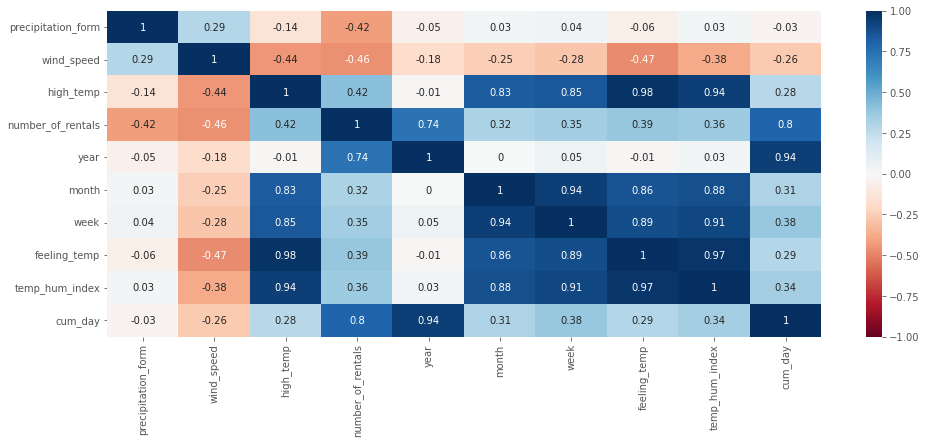

In [330]:
corr2 = np.round(bicycle_new.corr(),2)
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr2,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

In [331]:
desc = bicycle_new.describe()

In [332]:
desc

,precipitation_form,wind_speed,high_temp,number_of_rentals,year,month,week,feeling_temp,temp_hum_index,cum_day
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,1.133277,2.480963,23.384733,59574.978022,2019.000000,5.000000,20.047619,20.032511,313.160396,137.000000
std,0.295574,0.884397,5.204605,27659.575774,0.817996,0.813489,3.767304,5.580008,302.579209,78.952517
min,1.000000,0.753000,9.895000,1037.000000,2018.000000,4.000000,13.000000,5.784498,-511.089885,1.000000
25%,1.000000,1.820000,19.842000,36761.000000,2018.000000,4.000000,17.000000,16.447767,87.599597,69.000000
50%,1.000000,2.411000,24.158000,63032.000000,2019.000000,5.000000,20.000000,20.991814,334.421543,137.000000
75%,1.091988,2.924000,27.526000,81515.000000,2020.000000,6.000000,23.000000,24.733559,545.539287,205.000000
max,2.718282,5.607000,33.421000,110377.000000,2020.000000,6.000000,27.000000,29.735158,885.049255,273.000000


## 3. Model

### Fit

In [333]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(scaled_X, y)

In [334]:
X = bicycle_new.drop('number_of_rentals', axis=1)
y = bicycle_new['number_of_rentals']
t_X = t_bicycle_new.copy()

### feature engineering

In [335]:
col_len = len(X.columns)
for data in [X, t_X]:
  for col1 in data.columns[:col_len] :
    for col2 in data.columns[:col_len] :
      data['{}*{}'.format(col1, col2)] = data[col1] * data[col2]

In [336]:
X.columns

Index(['precipitation_form', 'wind_speed', 'high_temp', 'year', 'month',
       'week', 'feeling_temp', 'temp_hum_index', 'cum_day',
       'precipitation_form*precipitation_form',
       'precipitation_form*wind_speed', 'precipitation_form*high_temp',
       'precipitation_form*year', 'precipitation_form*month',
       'precipitation_form*week', 'precipitation_form*feeling_temp',
       'precipitation_form*temp_hum_index', 'precipitation_form*cum_day',
       'wind_speed*precipitation_form', 'wind_speed*wind_speed',
       'wind_speed*high_temp', 'wind_speed*year', 'wind_speed*month',
       'wind_speed*week', 'wind_speed*feeling_temp',
       'wind_speed*temp_hum_index', 'wind_speed*cum_day',
       'high_temp*precipitation_form', 'high_temp*wind_speed',
       'high_temp*high_temp', 'high_temp*year', 'high_temp*month',
       'high_temp*week', 'high_temp*feeling_temp', 'high_temp*temp_hum_index',
       'high_temp*cum_day', 'year*precipitation_form', 'year*wind_speed',
       'year*

In [337]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [338]:

# model = XGBRegressor(booster='gbtree',
#              n_estimators=50,
#              learning_rate=0.1,
#              max_depth=5,
#              n_jobs=-1,
#              random_state=0)

# model.fit(X, y)

### Predict

In [339]:
# y_hat = model.predict(X)

# nmae = NMAE(y, y_hat)

# print(f'모델 NMAE : {nmae}')

### CV

In [444]:
##### from sklearn.model_selection import cross_validate, cross_val_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor

#  for n in range(1,10):
#      for m in range(50,1000,50):

params = []
mean_test_scores = []
mean_train_scores = []
for l in tqdm_notebook(np.arange(1,10)):
#for n in tqdm_notebook(range(5000,10000,100)):
  n_split = 5

  spliter = KFold(n_splits=n_split)

  test_scores = []
  train_scores = []

  # model = XGBRegressor(booster='gbtree',
  #               n_estimators=120,
  #               learning_rate=l,
  #               max_depth=5,
  #               n_jobs=-1,
  #               random_state=0,
  #               reg_lambda=0.03,
  #               #reg_alpha=l,
  #               objective='reg:squarederror'
  #               )
  model = RandomForestRegressor(n_estimators=200, 
                              max_depth=l, 
                              n_jobs=-1,
                              #criterion=NMAE,
                              random_state=0)

  for train_index, test_index in spliter.split(X, y):
      train_X = X.iloc[train_index,:]
      test_X = X.iloc[test_index,:]
      train_y = y[train_index]
      test_y = y[test_index]

      model.fit(train_X, train_y)

      pred_test_y = model.predict(test_X)
      pred_train_y = model.predict(train_X)

      test_scores.append(NMAE(test_y, pred_test_y))
      train_scores.append(NMAE(train_y, pred_train_y))
    
  params.append(l)
  mean_test_scores.append(np.mean(test_scores))
  mean_train_scores.append(np.mean(train_scores))

  print(' params : ', l, ' score : ', mean_test_scores[-1], mean_train_scores[-1])

      # model.fit(X, y)
      # y_hat = model.predict(X)
      # nmae = NMAE(y, y_hat)
      # print(f'모델 NMAE : {nmae}')

  0%|          | 0/9 [00:00<?, ?it/s]

 params :  1  score :  0.808084632754068 0.5578747620686502
 params :  2  score :  0.6863811994631065 0.3374669775860106
 params :  3  score :  0.577390723298994 0.21531112128412527
 params :  4  score :  0.5394356517805163 0.15631075904916428
 params :  5  score :  0.5313698547834103 0.12624931282300061
 params :  6  score :  0.5171002017043193 0.11033168009815009
 params :  7  score :  0.5090432619815749 0.10277249507095873
 params :  8  score :  0.5122714392371581 0.09915860330362954
 params :  9  score :  0.5101538123523074 0.0963924824268025


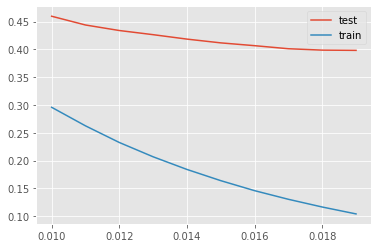

In [384]:
plt.plot(params, mean_test_scores, label='test')
plt.plot(params, mean_train_scores, label='train')
plt.legend()
plt.show()

In [435]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

model = XGBRegressor(booster='gbtree',
             n_estimators=200,
             learning_rate=0.05,
             max_depth=5,
             n_jobs=-1,
             #reg_alpha=0.001,
             #reg_lambda=1e-10,
             random_state=0,
             objective='reg:squarederror')

# model.fit(X,y)
# y_hat = model.predict(X)
# model = RandomForestRegressor(n_estimators=200, 
#                             max_depth=7, 
#                             n_jobs=-1,
#                             #criterion=NMAE,
#                             random_state=0)

model.fit(X,y)
y_hat = model.predict(X)

## 4.Evaluate Model

## 5.Submission

In [436]:
submission = pd.read_csv(dir + '_data/sample_submission.csv')

In [437]:
result = model.predict(t_X)

In [438]:
submission['number_of_rentals'] = result

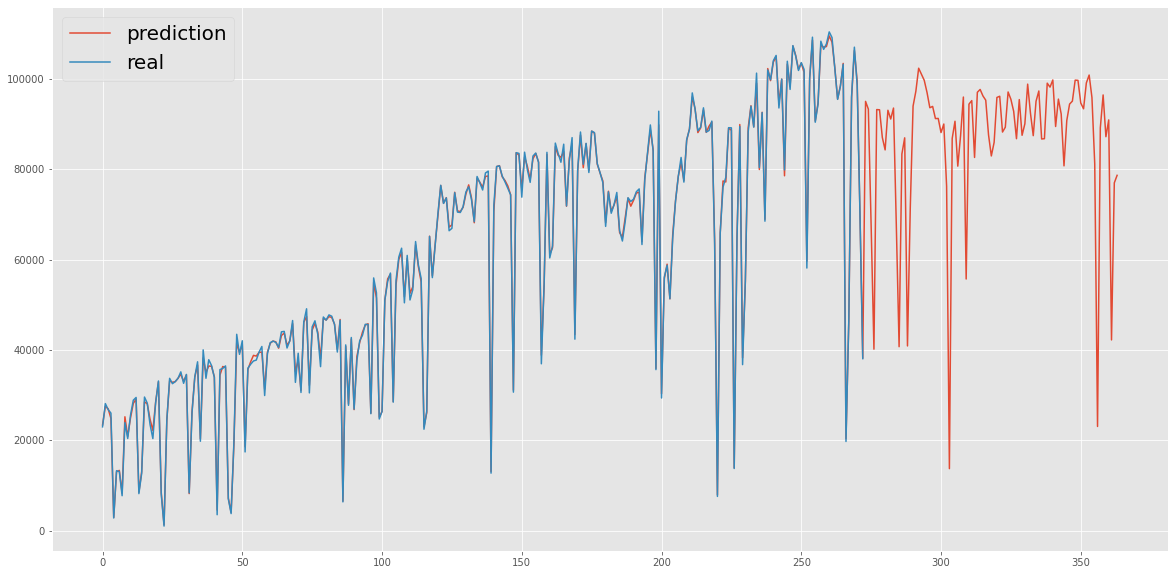

In [439]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([y_hat, result]), label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

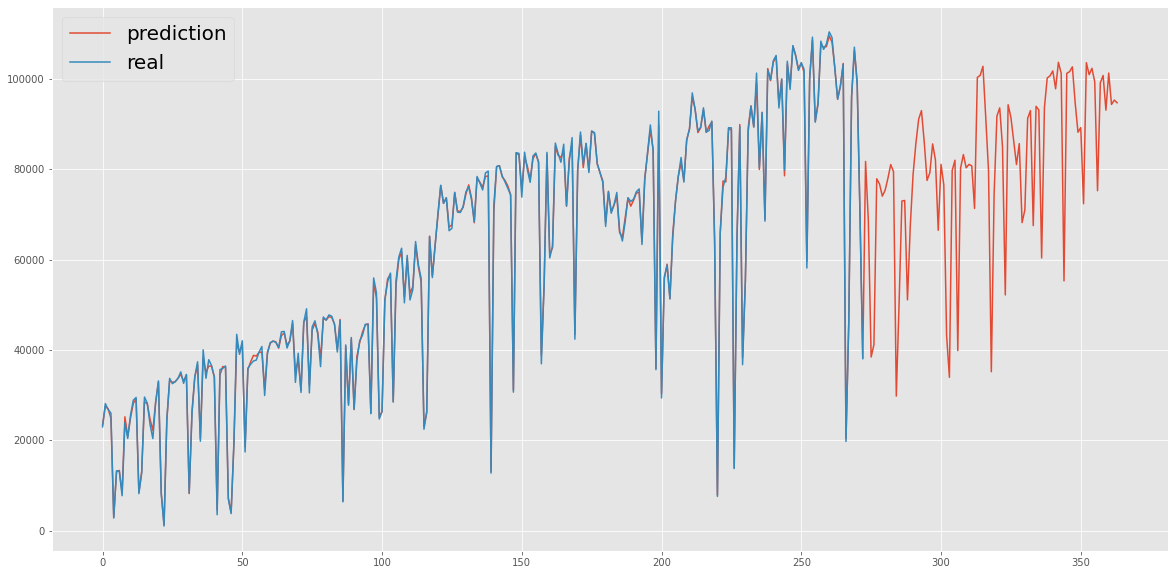

In [440]:
rf = pd.read_csv(dir + '_result/4.RandomForrest.csv')

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([y_hat, list(rf['number_of_rentals'])]), label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

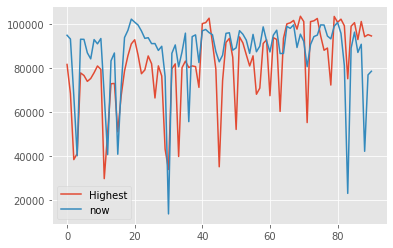

In [443]:
plt.plot(list(rf['number_of_rentals']), label='Highest')
plt.plot(result, label='now')
plt.legend()

In [442]:
submission.to_csv(dir + '_result/13.xgb_feature.csv', index=False)